<hr style="border:3px solid coral"></hr>

# Cartesian communicators

<hr style="border:3px solid coral"></hr>


#### 1d case
When we distribute one dimensional data to multiple ranks, we divide up our Cartesian grid so that rank 0 is near the left edge of our domain, and the highest rank is at the right edge.  This is typically done using the rank to compute subintervals of the domain. 

    int N_local = N/nprocs;
    double dw = (b-a)/nprocs;
    
    # Processor rank used to determine subintervals of our 1d grid
    double a_local = a + rank*dw;     
    double b_local = a_local + dw;
    
Because we know how the data is laid out, we know how to communicate boundary condition data between processors.      
   
#### 2d case    
When we consider two dimensional domains, however, it is no longer so straightforward to tile the domain with processors.  Even among a few obvious choices, we would need to decide whether we 

* Tile in the x direction

* Tile in the y direction

* Use some other optimal "space filling" strategy for ensure optimal communication performance between ranks.

MPI has anticipated this problem, and provides routines to facilitate grid communication for higher dimensional grids.  These routines are 

* `MPI_Cart_create` : Create a virtual Cartesian communicator

* `MPI_Cart_coords` : Obtain local coordinates within the communicator

* `MPI_Cart_get` : Get information from Cartesian communicator

These routines allow us to set up a "virtual" network which allows us to communicate using an $(I,J)$ grid of virtual ranks.  Moreover, virtual communicators will allow us to easily handle periodic data. 

Read more about [Virtual topologies](https://hpc-tutorials.llnl.gov/mpi/virtual_topologies/).

### Using subgrid communicators. 

* <a href="#ghost_2d_simple">Exchanging 2d ghost data</a> (simplified single DOF/processor example).

* <a href="#ghost_2d">Exchanging 2d ghost data</a> (realistic example)


* <a href="#matrix_norm">Matrix 1-norm and inf-norm</a> using a subgrid communicator. 


* <a href="#parallel_IO">Parallel Output</a> using a subgrid communicator. 



<hr style="border:3px solid coral"></hr>

## What is a Cartesian communicator?

<hr style="border:3px solid coral"></hr>

So far, we have been using a default communicator `MPI_WORLD_COMM`.  This object stores information about the number of processors available,  the current rank, and is passed to most other MPI routines involved in data communication.  

The communicator can tell us

* How many ranks are currently being used (e.g. `nprocs`)

* The current rank (e.g. `rank`)





<hr style="border:2px solid coral"></hr>

## Shift data and replace in a 1d array

<hr style="border:2px solid coral"></hr>

In this example, each processor in a 1d array stores a single integer value.  We create a Cartesian communicator and then shift each value to a neighboring processor. 

We use the MPI routine `MPI_Cart_create`, with signature

    int MPI_Cart_create ( MPI_Comm comm_old, int ndims, int *dims, int *periods,
                                int reorder, MPI_Comm *comm_cart )
                                
where

* **comm_old** is the existing communicator (e.g. `MPI_COMM_WORLD`)

* **ndims** Grid dimensions (1,2,3,...)

* **dims** an array determine size of grid in each direction.  **dims** should be an array of dimension `ndims`. 

* **periods**  Periodicity of each direction. 

* **reorder** Reorder ranks (set to 0 or 1)

* **comm_cart** Address of new communicator. 

Once we create a new communicator, we can no longer rely on our own rank layout, but instead must query the communicator to get the rank of neighboring processors.  We will get this neighboring rank information using the `MPI_Cart_shift` routine.

    int MPI_Cart_shift ( MPI_Comm comm, int direction, int displ,
                               int *source, int *dest )
                               
* **comm** The newly created communicator

* **direction** The direction to shirt (+1, -1)

* **displ** Displacement value

* **source** Source rank (an output value)

* **dest** Destination rank (an output value)


In the example below, we  shift an integer value to the left or right in our original array. 

* A "displacement" value determines whether we shift right or left. 

    * If **displacement** is 1, each processor sends its value to its right neighbor

    * If **displacement** is -1, each processor sends its value to its left neighbor

If the domain is **periodic**, each processor has a neighbor.  If the domain is not periodic, then the left most processor does not have a left neighbor, and the rightmost processor does not have a right neighbor. 

We also use `MPI_Sendrecv_replace`, which combines a the send buffer and the receive buffer.  The send/receives are coordinated so that the send occurs before the value in the send buffer is replaced with a received value. 

In [ ]:
%%file cart_01.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>

enum
{
    LEFT=0,
    RIGHT
};

void main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    int root = 0;
    
    // #  Create a new communicator
    MPI_Comm comm_cart;  
    int ndim = 1;
    int dims = nprocs;
    int reorder = 0;        
    int periodicity[1] = {0};
    MPI_Cart_create(MPI_COMM_WORLD, ndim, &dims,  periodicity, reorder, &comm_cart);

    int maxdims = 2;
    int coords;
    MPI_Cart_coords(comm_cart, rank, maxdims, &coords);    
        
    // # Each processor stores a single integer
    int val = coords;  // # will be equal to rank in 1d case.
    
    int data[nprocs];
    MPI_Gather(&val,1,MPI_INTEGER,&data[0],1,MPI_INTEGER,root,MPI_COMM_WORLD);
    if (rank == root)
    {
        printf("Before shift : \n");
        printf("%8s : ","Rank");
        for(int p = 0; p < nprocs; p++)
            printf("%5d",p);
        printf("\n");
        
        printf("%8s : ","Value");
        for(int p = 0; p < nprocs; p++)
            printf("%5d",data[p]);
        printf("\n");
    }
    
    // # Shift information : 1: receive value from the left; -1 receive from right
    int displ = 1;
        
    int dir = 0;
    int nbr[2];
    MPI_Cart_shift(comm_cart, dir, displ, &nbr[LEFT], &nbr[RIGHT]);
    // # printf("rank : %d; source %d; dest %d\n",rank,nbr[LEFT],nbr[RIGHT]);
    
    int tag = 0;
    // int val_before = val;
    // # Only a send buffer is required, no recv. buffer.
    MPI_Sendrecv_replace(&val, 1, MPI_INTEGER, nbr[RIGHT], tag, 
                         nbr[LEFT], tag, comm_cart, MPI_STATUS_IGNORE);

    if (rank == 0)
    {
        printf("\n");        
        
        if (displ== 1)
            printf("Values are shifted to the right (displ = 1). ",displ);
        else
            printf("Values are shifted to the left (displ = -1). ",displ);
        
        if (periodicity[0] == 1)
            printf("Domain is periodic\n\n");
        else
            printf("Domain is not periodic\n\n");
    }
    
    MPI_Gather(&val,1,MPI_INTEGER,data,1,MPI_INTEGER,root,MPI_COMM_WORLD);
    if (rank == root)
    {
        printf("After shift : \n");
        printf("%8s : ","Rank");
        for(int p = 0; p < nprocs; p++)
            printf("%5d",p);
        printf("\n");
        
        printf("%8s : ","Value");
        for(int p = 0; p < nprocs; p++)
            printf("%5d",data[p]);
        printf("\n");
    }

    MPI_Finalize();
}

In [ ]:
%%bash 

mpicc -o cart_01 cart_01.c

mpirun -n 8 cart_01

#### Question

What happens to values at either end of the array? 

* <a id="ghost_1d_simple"></a>


<hr style="border: 2px solid coral"></hr>

# Filling ghost cell values (1d)

<hr style="border: 2px solid coral"></hr>

The Cartesian communicator is particularly useful in filling ghost cells in gridded data from neighboring ranks. 

Below, each processor creates a length 3 array of values $x_{j}$, $j = -1,0,1$.  Each processor computes a value at $x_0$.  

Viewing these values as values of the function $f(x) = x$, each processor computes a value $f(x_0)$.  We can then approximate a derivative $f'(x) = 1$ at $x_0$ using the centered formula

\begin{equation}
x_0 = \frac{x_{1} - x_{-1}}{2h}
\end{equation}

where $x_0$ is local to each rank.  To obtain ghost values at $x_{-1}$ and $x_1$ use `MPI_Sendrecv`.  

To get the source and destination ranks needed for `MPI_Sendrecv`, we create a Cartesian communicator, and use `MPI_Cart_shift` to determine source and destination ranks.

<center>
<table style="margin:20px; border:1px solid black">
<caption>Four processors, each with a single degree of freedom located at cell-centers.       <tr>
        <td><img width=300 style="padding:20px" src="./cart_01.png"></img></td>
        <td><img width=300 style="padding:20px" src="./cart_02.png"></img></td>
    </tr>
</caption>    
</table>    
</center>

To fill all ghost cells, we need to do both a left shift and a right shift. 

At the endpoints, we have to fill in ghost cell values from known values.  To detect that we are at endpoints we can compare a source or destination rank to the value `MPI_PROC_NULL`. 


In [522]:
# Leave blank

In [523]:
%%file cart_02.c

#include <mpi.h>
#include <math.h>

#include <stdio.h>
#include <stdlib.h>

enum
{
    LEFT=0,
    RIGHT
};

enum
{
    DIR_X=0
};

double f(double x)
{
    return x*x/2;
}

void main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    int root = 0;
    
    // # Create Cartesian communicator
    MPI_Comm comm_cart;
    int ndim = 1;  // # 1 dimensional communicator (useful for 1d)
    int dims[ndim],periodicity[ndim];
    int reorder = 0;
    
    dims[DIR_X] = nprocs;
    periodicity[DIR_X] = 0;
    MPI_Cart_create(MPI_COMM_WORLD, ndim, dims,  periodicity, reorder, &comm_cart);
    
    // # Get coordinate of current rank
    int I;
    {
        int maxdims = 2;
        MPI_Cart_coords(comm_cart, rank, maxdims, &I);            
    }
    
    // # construct local array  and index as : q[-1],q[0],q[1]    
    double qmem[3], *q;
    {
        q = &qmem[1];
    }

    // # Width of each processor "domain".
    double a,b,h,x;
    {
        a = 0;     
        b = 1;
        h = (b-a)/dims[DIR_X];
        
        // # Fill in cell centered mesh locations using coordinate I (not rank).
        x = a + (I + 0.5)*h;  // # Value at center of processor domain
        q[0] = f(x);
    }
    
    
    // # Write out data
    int grid_coords[nprocs];
    double x_grid[nprocs]; 
    
    MPI_Gather(&I,1,MPI_INTEGER,grid_coords,1,MPI_INTEGER,root,MPI_COMM_WORLD);
    MPI_Gather(&x,1,MPI_DOUBLE,x_grid,1,MPI_DOUBLE,root,MPI_COMM_WORLD);
    if (rank == root)
    {
        printf("(I) (x) coordinates for each rank\n");
        for(int p = 0; p < nprocs; p++)        
            printf("%5d (%d) (%8.4f)\n",p,grid_coords[p],x_grid[p]);
        printf("\n");        
    }        

    int nbr[2];   // # Store left/right neighbors
        
    // #  Fill ghost value at the left : q[-1]
    {
        int dir = DIR_X;  // # only direction 0 in 1d
        int disp = 1;
        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[LEFT], &nbr[RIGHT]);

        // # Need to check if we have valid source rank from the left
        if (nbr[LEFT] == MPI_PROC_NULL)
            q[-1] = f(x-h);
    
        // # Send values to the right;  receive from the left
        int tag = 0;
        MPI_Sendrecv(&q[0], 1, MPI_DOUBLE, nbr[RIGHT], tag, 
                     &q[-1], 1, MPI_DOUBLE, nbr[LEFT], tag, 
                     comm_cart, MPI_STATUS_IGNORE);        
    }

    // #  Fill ghost value at the right : q[1]
    {
        int dir = DIR_X;
        int disp = -1;  
        MPI_Cart_shift(comm_cart, dir, disp, &nbr[RIGHT], &nbr[LEFT]);

        // # Need to check if we have valid source at the right
        if (nbr[RIGHT] == MPI_PROC_NULL)
            q[1] = f(x+h);
    
        // # Send values to the left;  receive from the right
        int tag = 1;
        int ierr = MPI_Sendrecv(&q[0], 1, MPI_DOUBLE, nbr[LEFT], tag, 
                                &q[1], 1, MPI_DOUBLE, nbr[RIGHT], tag, 
                                comm_cart, MPI_STATUS_IGNORE);        
    }

    // # Compute a derivative using left and right values
    double L = (q[1] - 2*q[0] + q[-1])/(h*h);
    
    // # Write out Laplacian
    double data[nprocs];
    MPI_Gather(&L,1,MPI_DOUBLE,data,1,MPI_DOUBLE,root,MPI_COMM_WORLD);
    if (rank == root)
    {
        printf("\n");
        printf("Laplacian of f(x) = 0.5*x^2\n");
        for(int p = 0; p < nprocs; p++)
            printf("%5d %8.4f\n",p,data[p]);
        printf("\n");        
    }
    

    MPI_Finalize();
}

Overwriting cart_02.c


In [524]:
%%bash 

mpicc -o cart_02 cart_02.c

mpirun -n 8 cart_02

(I) (x) coordinates for each rank
    0 (0) (  0.0625)
    1 (1) (  0.1875)
    2 (2) (  0.3125)
    3 (3) (  0.4375)
    4 (4) (  0.5625)
    5 (5) (  0.6875)
    6 (6) (  0.8125)
    7 (7) (  0.9375)


Laplacian of f(x) = 0.5*x^2
    0   1.0000
    1   1.0000
    2   1.0000
    3   1.0000
    4   1.0000
    5   1.0000
    6   1.0000
    7   1.0000



<a id="ghost_2d_simple"></a>

<hr style="border: 2px solid coral"></hr>

# Filling ghost cell values (2d)

<hr style="border: 2px solid coral"></hr>

Where the real power of the Cartesian communicator comes in is for higher dimensional grids.  

Below, we alllocate a 2d array, and use a two dimensional communicator. 

To facilitate using finite difference schemes in 2d, we use the same trick as in 1d.  

<center>
<table style="margin:20px; border:1px solid black">
    <caption>Local memory layout for two dimensional grids with ghost cells.</caption>
    <tr>
        <td><img width=400 style="padding-top:20px" src="./cart_03.png"></img></td>
        <td><img width=400 style="padding-top:20px" src="./cart_04.png"></img></td>
    </tr>
</table>    
</center>

This allows us to apply finite difference stencils in two dimensions.   To compute a Laplacian, we can apply the two dimensional finite difference stencil (commonly called the "5-point stencil") as 

\begin{equation}
\nabla^2 u(x) \approx \frac{u_{-1,0} + u_{1,0} + u_{0,-1} + u_{1,1}  - 4 u_{0,0}}{h^2}
\end{equation}

<center>
<table style="margin:20px; border:1px solid black">
    <caption>$4 \times 4$ grid of 16 processors with a single DOF per processor.</caption>
    <tr>
        <td><img width=300 style="padding-top:20px" src="./cart_05.png"></img></td>
        <td><img width=100 style="padding-top:20px" src="./cart_06.png"></img></td>
    </tr>
</table>    
</center>    

Applying this formula to the function $u(x,y) = \frac{1}{4}(x^2 + y^2)$, we have $\nabla^2 u = u_{xx} + u_{yy} = 1$. 

In the code below, we do the following on each processor. 

* Create a $3 \times 3$ grid containing a single degree of freedom surrounded by a buffer layer to hold ghost cell values copied from neighboring processors.   These values can be indexed as 

      q[i][j], i,j = -1,0,1

* Evaluate the function `q[0][0] = f(x)` at single DOF location on each processor. 

* Use a Cartesian communicator to exchange data with neighboring processors

* At the domain boundaries fill ghost cells with known function values.  

* Evaluate the 5-point stencil. 



In [525]:
# Leave blank

In [526]:
%%file cart_03.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>

enum
{
    LEFT=0,
    RIGHT,
    DOWN,
    UP
};

enum
{
    DIR_X = 0,
    DIR_Y
};

double f(double x, double y)
{
    return (x*x + y*y)/4.0;
}

void main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int root = 0;
    
    int ndim = 2;
    int dims[ndim];
    if (argc == 3)
    {
        // # Number of processors in each direction.  Product should equal nprocs.
        dims[DIR_X] = atoi(argv[1]);
        dims[DIR_Y] = atoi(argv[2]);
    }
    else
        if (rank == 0)
        {
            printf("Usage : \n");
            printf("cart_03 <dim 0> <dim 1>\n");
            exit(0);            
        }

    if (rank == root)
        if (nprocs != dims[DIR_X]*dims[DIR_Y])
        {
            printf("dim[0]*dim[1] != nprocs\n");
            exit(0);
        }
        
    // # Create Cartesian communicator
    MPI_Comm comm_cart;
    int periodicity[2] = {0,0};
    int reorder = 0;
    MPI_Cart_create(MPI_COMM_WORLD, ndim, dims,  periodicity, reorder, &comm_cart);
    
    // # Create a 3x3 block of memory
    double qmem[9], *qrows[3], **q;
    {
        for(int i = 0; i < 3; i++)
            qrows[i] = &qmem[3*i + 1];
        q = &qrows[1];        
    }
    
    // # Get coordinate of current rank
    int I, J,coords[2];
    {
        int maxdims = 2;
        MPI_Cart_coords(comm_cart,rank,maxdims,coords);

        I = coords[DIR_X];
        J = coords[DIR_Y];                
    }
    
    // # Set grid values
    double hx,hy,x,y;
    {
        double a = 0, b = 1;    // # Assume domain is square.
        hx = (b-a)/dims[DIR_X];  // # processor domain has a "single mesh cell"  
        hy = (b-a)/dims[DIR_Y];
        x = a + (I+0.5)*hx;
        y = a + (J+0.5)*hy;
    
        // # Value
        q[0][0] = f(x,y);           
    }
    
    // # write out all 2d coordinates.
    int grid_coords[2*nprocs];
    double xy[2] = {x,y};
    double xy_grid[2*nprocs];
    
    MPI_Gather(coords,2,MPI_INTEGER,grid_coords,2,MPI_INTEGER,root,MPI_COMM_WORLD);
    MPI_Gather(xy,2,MPI_DOUBLE,xy_grid,2,MPI_DOUBLE,root,MPI_COMM_WORLD);
    if (rank == root)
    {
        printf("%8s     (%2s,%2s),   (%8s,%8s)\n","rank","I","J","x","y");
        for(int p = 0; p < nprocs; p++)
        {
            int I = grid_coords[2*p];
            int J = grid_coords[2*p+1];
            double x = xy_grid[2*p];
            double y = xy_grid[2*p + 1];
            printf("%8d     (%2d,%2d),   (%8.4f,%8.4f)\n",p,I,J,x,y);   
        }
        printf("\n");        
    }        

    // # Store source/dest neighbors
    int nbr[4];

    // # Get values at left : q[-1][0]
    {
        int dir = DIR_X;    
        int disp = 1;
        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[LEFT], &nbr[RIGHT]);

        if (nbr[LEFT] == MPI_PROC_NULL)
            q[-1][0] = f(x-hx,y);
    
        int tag = 0;
        MPI_Sendrecv(&q[0][0], 1, MPI_DOUBLE, nbr[RIGHT], tag, 
                     &q[-1][0], 1, MPI_DOUBLE, nbr[LEFT], tag, 
                     comm_cart, MPI_STATUS_IGNORE);  
        
    }

    // # Get values at the right : q[1][0]
    {
        int dir = DIR_X;
        int disp = -1;  
        MPI_Cart_shift(comm_cart, dir, disp, &nbr[RIGHT], &nbr[LEFT]);

        if (nbr[RIGHT] == MPI_PROC_NULL)
            q[1][0] = f(x+hx,y);
    
        int tag = 1;
        int ierr = MPI_Sendrecv(&q[0][0], 1, MPI_DOUBLE, nbr[LEFT], tag, 
                                &q[1][0], 1, MPI_DOUBLE, nbr[RIGHT], tag, 
                                comm_cart, MPI_STATUS_IGNORE);        
    }

    // #  Fill value at the bottom : q[0][-1]
    {
        int dir = DIR_Y;    
        int disp = 1;
        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[DOWN], &nbr[UP]);

        if (nbr[DOWN] == MPI_PROC_NULL)
            q[0][-1] = f(x,y-hy);

        int tag = 2;
        MPI_Sendrecv(&q[0][0], 1, MPI_DOUBLE, nbr[UP], tag, 
                     &q[0][-1], 1, MPI_DOUBLE, nbr[DOWN], tag, 
                     comm_cart, MPI_STATUS_IGNORE);        
    }

    // #  Fill value at the  top : q[0][1]
    {
        int dir = DIR_Y;
        int disp = -1;  
        MPI_Cart_shift(comm_cart, dir, disp, &nbr[UP], &nbr[DOWN]);
    
        if (nbr[UP] == MPI_PROC_NULL)
            q[0][1] = f(x,y+hy);

        int tag = 3;
        int ierr = MPI_Sendrecv(&q[0][0], 1, MPI_DOUBLE, nbr[DOWN], tag, 
                                &q[0][1], 1, MPI_DOUBLE, nbr[UP], tag, 
                                comm_cart, MPI_STATUS_IGNORE);        
    }

    // # Compute a Laplacian at cell center.
    double L = (q[-1][0] + q[1][0] - 2*q[0][0])/(hx*hx) + 
               (q[0][-1] + q[0][1] - 2*q[0][0])/(hy*hy);
    
    // # Write out the Laplacian
    double data[nprocs];
    MPI_Gather(&L,1,MPI_DOUBLE,data,1,MPI_DOUBLE,root,MPI_COMM_WORLD);
    if (rank == root)
    {
        printf("\n");
        printf("Laplacian of f = 0.5*(x^2 + y*2) (cell-centers): \n");
        for(int p = 0; p < nprocs; p++)
            printf("%5d %8.4f\n",p,data[p]);
        printf("\n");        
    }
    MPI_Finalize();
}

Overwriting cart_03.c


In [527]:
%%bash 

mpicc -o cart_03 cart_03.c

# mpirun -n <nprocs> cart_03 <dim[0]> <dim[1]>
# where dim[0]*dim[1] = nprocs

mpirun -n 16 cart_03 1 16

    rank     ( I, J),   (       x,       y)
       0     ( 0, 0),   (  0.5000,  0.0312)
       1     ( 0, 1),   (  0.5000,  0.0938)
       2     ( 0, 2),   (  0.5000,  0.1562)
       3     ( 0, 3),   (  0.5000,  0.2188)
       4     ( 0, 4),   (  0.5000,  0.2812)
       5     ( 0, 5),   (  0.5000,  0.3438)
       6     ( 0, 6),   (  0.5000,  0.4062)
       7     ( 0, 7),   (  0.5000,  0.4688)
       8     ( 0, 8),   (  0.5000,  0.5312)
       9     ( 0, 9),   (  0.5000,  0.5938)
      10     ( 0,10),   (  0.5000,  0.6562)
      11     ( 0,11),   (  0.5000,  0.7188)
      12     ( 0,12),   (  0.5000,  0.7812)
      13     ( 0,13),   (  0.5000,  0.8438)
      14     ( 0,14),   (  0.5000,  0.9062)
      15     ( 0,15),   (  0.5000,  0.9688)


Laplacian of f = 0.5*(x^2 + y*2) (cell-centers): 
    0   1.0000
    1   1.0000
    2   1.0000
    3   1.0000
    4   1.0000
    5   1.0000
    6   1.0000
    7   1.0000
    8   1.0000
    9   1.0000
   10   1.0000
   11   1.0000
   12   1.0000
   13

<a id="ghost_2d"></a>

<hr style="border: 2px solid coral"></hr>

## Filling ghost cell values for realistic gridded data

<hr style="border: 2px solid coral"></hr>

In the above, we only used a single degree of freedom per processor. While this illustrates the use of the Cartesian communicator, the extension to gridded data may not be completely obvious.  Below, we illustrate a simple example of a 1d array of Cartesian grids that communicate ghost cell values at their left and right edges.   


In [519]:
%%file cart_04_all.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>

enum
{
    LEFT=0,
    RIGHT,
    DOWN,
    UP
};

enum
{
    DIR_X = 0,
    DIR_Y
};

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double** allocate_2d(int n, int m, int mbc)
{
    int rows = n + 2*mbc;
    int cols = m + 2*mbc; 

    double   *qmem = malloc(rows*cols*sizeof(double));
    double **qrows = malloc(rows*sizeof(double*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    return &qrows[mbc];
}

void free_2d(double ***q,int mbc)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

double qtrue(double x, double y)
{
    return (x*x + y*y)/4.0;
    //return sin(x)*sin(y);
}

Overwriting cart_04_all.c


In [520]:
%%file cart_04_rhs.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>


#include "cart_04_all.c"

void comm(int N, double **q, MPI_Comm comm_cart)
{
    // # Store source/dest neighbors
    int nbr[2];
    double *sendbuf = allocate_1d(N,0);
    double *recvbuf = allocate_1d(N,0);
    
    
    // # Get values at left : q[-1][j]
    {
        int dir = DIR_X;    
        int disp = 1;
        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[LEFT], &nbr[RIGHT]);
        
        for(int j = 0; j < N; j++)
            sendbuf[j] = q[N-1][j];  // # Data sent to the right processor
        
        int sendtag = 0;
        int recvtag = 0;
        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[RIGHT], sendtag, 
                     recvbuf, N, MPI_DOUBLE, nbr[LEFT], recvtag, 
                     comm_cart, MPI_STATUS_IGNORE);         

        if (nbr[LEFT] != MPI_PROC_NULL)
            for(int j = 0; j < N; j++)
                q[-1][j] = recvbuf[j];  // # Data sent to the right processor                
    }

    // # Get values at the right : q[N][j]
    {
        int dir = DIR_X;
        int disp = -1;  
        MPI_Cart_shift(comm_cart, dir, disp, &nbr[RIGHT], &nbr[LEFT]);

        for(int j = 0; j < N; j++)
            sendbuf[j] = q[0][j];  // # Data sent to the left processor

        int sendtag = 1;
        int recvtag = 1;
        int ierr = MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[LEFT],sendtag, 
                                recvbuf, N, MPI_DOUBLE, nbr[RIGHT], recvtag, 
                                comm_cart, MPI_STATUS_IGNORE); 
        if (ierr != MPI_SUCCESS)
        {
            printf("Something bad happened!\n");
            exit(0);
        }
        
        if (nbr[RIGHT] != MPI_PROC_NULL)
            for(int j = 0; j < N; j++)
                q[N][j] = recvbuf[j];
    }       
}


void matvec(int N, double **q, double **L, MPI_Comm comm_cart)
{
    // # Get current coordinate in comm_cart
    int maxdims = 1;
    int coords[maxdims];
    int periodicity[maxdims];
    int dims[maxdims];        
    
    MPI_Cart_get(comm_cart,maxdims,dims,periodicity,coords);
    int I = coords[DIR_X];    
    int Imax = dims[DIR_X];
    
    // # Get values at left : q[-1][j]
    if (I == 0)  
        for(int j = 0; j < N; j++)
            q[-1][j] = -q[0][j];     // # Assume Dirichlet conditions

    
    // # Get values at right : q[N][j]
    if (I == Imax-1) 
        for(int j = 0; j < N; j++)
            q[N][j] = -q[N-1][j];     // # Assume Dirichlet conditions
        
    // # Fill value at the bottom and top : q[i][-1], q[i][N]
    // # Recall : We are assuming a 1 x P (P processors in DIR_X, 1 in DIR_Y) 
    // # topology, so we don't have any neighbors. Above or below this rank.
    {
        for(int i = 0; i < N; i++)
        {
            q[i][-1] = -q[i][0];
            q[i][N] = -q[i][N-1];
        }
    }
        
    // # Communicate internal boundary data
    comm(N, q, comm_cart);
        
    // # Compute Laplacian (with homogenenous data)
    for(int i = 0; i < N; i++)    
        for(int j = 0; j < N; j++)
            L[i][j] = q[i-1][j] + q[i+1][j] + q[i][j-1] + q[i][j+1] - 4*q[i][j]; 
}
 

int compute_RHS(int N, double **q, double **F, MPI_Comm comm_cart)
{
    // # Compute right hand side as result of applying five-point Laplacian to 
    // # known solution.
    double **qh = allocate_2d(N,N,1);
    
    for(int i = 0; i < N; i++)
        for(int j = 0; j < N; j++)
            qh[i][j] = q[i][j];
        
    matvec(N,qh,F,comm_cart);   
    
    // # Fix RHS with inhomogeneous data (IGNORE - NOT RELEVANT FOR HOMEWORK)    

    // # Get current coordinate in comm_cart
    int maxdims = 1;
    int coords[maxdims];
    int periodicity[maxdims];
    int dims[maxdims];        
    
    MPI_Cart_get(comm_cart,maxdims,dims,periodicity,coords);
    int I = coords[DIR_X];    
    int Imax = dims[DIR_X];    

    for(int j = 0; j < N; j++)
    {
        if (I == 0)
            F[0][j] +=  (q[-1][j] + q[0][j]);
        
        if (I == Imax-1)
            F[N-1][j] += (q[N-1][j] + q[N][j]); 
    }

    for(int i = 0; i < N; i++)
    {
        F[i][0] += (q[i][0] + q[i][-1]);
        F[i][N-1] += (q[i][N-1] + q[i][N]);
    }
}



Overwriting cart_04_rhs.c


In [521]:
%%file cart_04.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>

#include "cart_04_rhs.c"

void main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int root = 0;
    
    int N;
    if (argc == 2)
        N = atoi(argv[1]);
    else
        if (rank == 0)
        {
            printf("cart_04 <N>\n");
            exit(0);            
        }

    // # Domain
    int P = nprocs;
    double a = 0;
    double b = a + P;
    

    // # Create Cartesian communicator
    int ndim = 1;  // # 1 dimensional communicator (useful for 1d)
    int dims[ndim],periodicity[ndim];
    int reorder = 0;
    
    dims[DIR_X] = nprocs;
    periodicity[DIR_X] = 0;

    MPI_Comm comm_cart;
    MPI_Cart_create(MPI_COMM_WORLD, ndim, dims,  periodicity, reorder, &comm_cart);

    // # Get coordinate of current rank
    int I,coords[ndim];
    {
        int maxdims = 1;
        MPI_Cart_coords(comm_cart,rank,maxdims,coords);
        I = coords[DIR_X];
    }
    
    // # Create domain  [0,P]x[0,1], where P=nprocs
    double dw = (b-a)/dims[DIR_X];
    double a_local = a + I*dw;    
    double h = dw/N;  
    
    // # Set grid values and a true solution
    double *x = allocate_1d(N,1);
    double *y = allocate_1d(N,1);             
    double **q_soln = allocate_2d(N,N,1); 
    {
        for(int i = -1; i < N+1; i++)
        {
            x[i] = a_local + (i+0.5)*h;
            for(int j = -1; j < N+1; j++)
            {
                y[j] = a + (j + 0.5)*h;
                q_soln[i][j] = qtrue(x[i],y[j]);
            }
        }
    }
    
    double **F = allocate_2d(N,N,0);
    compute_RHS(N,q_soln,F,comm_cart); // # Apply a Laplacian
    

    // # Compute a Laplacian at cell center.
    double maxerr = 0;
    double Ltrue = 1;
    double h2 = h*h;
    for(int i = 0; i < N; i++)
        for(int j = 0; j < N; j++)
        {
            maxerr = fmax(maxerr,fabs(F[i][j]/h2 -  Ltrue));        
        }
    
    if (rank == root)
    {
        printf("\n");
        printf("Maximum error :  %12.4e\n",maxerr);
        printf("\n");        
    }
    free_2d(&q_soln,1);
    free_2d(&F,0);
    free_1d(&x,1);
    free_1d(&y,1);
    
    MPI_Finalize();
}

Overwriting cart_04.c


In [ ]:
%%bash 

mpicc -o cart_04 cart_04.c

# mpirun -n <nprocs> cart_04 <N>

mpirun -n 2 ./cart_04 4

<a id="matrix_norm"></a>

<hr style="border: 2px solid coral"></hr>

## Using subgrid  communicators to compute a matrix norm.

<hr style="border: 2px solid coral"></hr>

The matrix 1-norm (maximum column sum) and the inf-norm (maximum row sum) are trivial to compute in serial.  But when the matrix is distributed across a 2d array of processors, we need a  way to reduce across two dimensions.  

To do this, we will use the `MPI_Cart_sub` and `MPI_Group` to isolate groups of processors over which a reduction should take place.  

### Matrix creation

We create an $N \times N$ random matrix, where $N$ is divisible by powers of 2.    We will store this matrix and it into multiple processors.  We will distribute a single entry per processor.  

In [1]:
%reset -f

In [2]:
from numpy import *
from numpy.linalg import norm

In [3]:
dims = array([3,7])
nprocs = prod(dims)

data = arange(nprocs)

A = reshape(data,dims)

with printoptions(formatter={'float' : "{:5d}".format}):
    print(A)
print("")    

    
print(f'Max col sum (1-norm)   : {norm(A,1):.0f}')
print(f'Max row sum (inf-norm) : {norm(A,inf):.0f}')


[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]]

Max col sum (1-norm)   : 39
Max row sum (inf-norm) : 119


In [8]:
%%file matrix_01.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>

enum
{
    DIR_X = 0,
    DIR_Y
};

int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int root = 0;
    
    int ndims = 2;
    int dims[ndims], N, M;
    if (argc == 3)
    {
        dims[DIR_X] = atoi(argv[1]);
        dims[DIR_Y] = atoi(argv[2]);
        if (rank == root && dims[DIR_X]*dims[DIR_Y] != nprocs)
        {
            printf("dims[DIR_X]*dims[DIR_Y] != nprocs\n");
            exit(0);
        }
        else
        {
            N = dims[0];
            M = dims[1];
            if (rank == 0)
                printf("Matrix is %d x %d\n",N,M);
        }
    }
    else
        if (rank == 0)
        {
            printf("matrix_01 <dims 0> <dims 1>\n");
            exit(0);            
        }
    

    // # Create Cartesian communicator
    int periodicity[2] = {0,0};
    int reorder = 0;
    
    MPI_Comm comm_cart;
    MPI_Cart_create(MPI_COMM_WORLD, ndims, dims,  periodicity, reorder, &comm_cart);

    // # Get coordinate of current rank
    int coords[2];
    MPI_Cart_coords(comm_cart,rank,ndims,coords);
    int I = coords[DIR_X];
    int J = coords[DIR_Y];
    
    // # Each processor stores a single entry in the matrix
    double A = M*I + J;
    
    printf("Rank %2d : A[%d,%d] = %.0f\n",rank,I,J,A);
    
    // # Maximum column sum (1-norm)
    {
        MPI_Comm sub_cart;

        // # Reduce down each column;  store result in first row
        int remains[2] = {1,0};  // # Each i-index is sent to different subgrid
        MPI_Cart_sub(comm_cart,remains,&sub_cart);
        
        int RowID;
        MPI_Comm_rank(sub_cart,&RowID);
        
        int root_row = 0;  // # Result is stored in row 0
        double col_sum;
        double abs_Aij = fabs(A);
        MPI_Reduce(&abs_Aij, &col_sum, 1, MPI_DOUBLE, MPI_SUM, root_row, sub_cart); 
       
        // # Split communicators into rows
        MPI_Comm row_comm;
        MPI_Comm_split(MPI_COMM_WORLD, RowID, rank, &row_comm);
        
        if (RowID == 0)
        {
            int root_col = 0;
            double one_norm;
            MPI_Reduce(&col_sum, &one_norm, 1,MPI_DOUBLE,MPI_MAX,root_col,row_comm);        
            if (rank == root_col)
                printf("one-norm : %4.0f\n",one_norm);                    
        }
    }
        
    // # Maximum row sum (inf-norm)
    {
        MPI_Comm sub_cart;
        
        // # Reduce across each row;  store result in first column
        int remains[2] = {0,1};  // # j-indices all get sent to single subgrid communicator  
        MPI_Cart_sub(comm_cart,remains,&sub_cart);
        
        int ColID;
        MPI_Comm_rank(sub_cart,&ColID);
        
        int root_col = 0;
        double row_sum;
        double abs_Aij = fabs(A);
        MPI_Reduce(&abs_Aij,&row_sum, 1, MPI_DOUBLE,MPI_SUM,root_col,sub_cart); 
        
        // # Split communicator into columns   
        MPI_Comm column_comm;
        MPI_Comm_split(MPI_COMM_WORLD,ColID,rank,&column_comm);
        
        if (ColID == 0)
        {
            // # Only reduce down first column; store result in row 0.
            int root_row = 0;
            double inf_norm;
            MPI_Reduce(&row_sum, &inf_norm, 1,MPI_DOUBLE,MPI_MAX,root_row,column_comm);        
            if (rank == root_row)
                printf("inf-norm : %4.0f\n",inf_norm);                    
        }
    }

    MPI_Finalize();
}

Overwriting matrix_01.c


In [9]:
%%bash 

mpicc -o matrix_01 matrix_01.c

# mpirun -n <nprocs> cart_04 <N>

mpirun -n 16 ./matrix_01 4 4

Matrix is 4 x 4
Rank  0 : A[0,0] = 0
Rank  1 : A[0,1] = 1
Rank  2 : A[0,2] = 2
Rank  3 : A[0,3] = 3
Rank  4 : A[1,0] = 4
Rank  5 : A[1,1] = 5
Rank  6 : A[1,2] = 6
Rank  8 : A[2,0] = 8
Rank  9 : A[2,1] = 9
Rank 10 : A[2,2] = 10
Rank 11 : A[2,3] = 11
Rank 12 : A[3,0] = 12
Rank 13 : A[3,1] = 13
Rank 14 : A[3,2] = 14
Rank 15 : A[3,3] = 15
Rank  7 : A[1,3] = 7
one-norm :   36
inf-norm :   54


<a id="parallel_IO"></a>

<hr style="border : solid 2px coral"></hr>

## Parallel output for gridded data

<hr style="border : solid 2px coral"></hr>

This illustrates the use of a parallel output routine 

    void parallel_output(MPI_Comm comm_cart, int N, int Nx, int Ny, double **q, double *qbig)
    
where

* **comm_cart** is a Cartesian communicator

* **N** is the number of mesh cells in each direction in the global domain.   The assumption is that the global domain is an $N \times N$ cell-centered mesh.

* **Nx**, **Ny** Number of grid cells on each $N_x \times N_y$ local grid on a processor.  

* **q** Local 2d data on a cell-centered mesh of size $N_x \times N_y$, possibly with ghost cells.

* **qbig**  Global $N \times N$ 2d array, stored on rank 0.  If not on rank 0, this can be a NULL pointer.



In [316]:
%reset -f

In [12]:
%%file cart_05_all.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>

enum
{
    DIR_X = 0,
    DIR_Y
};

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double** allocate_2d(int n, int m, int mbc)
{
    int rows = n + 2*mbc;
    int cols = m + 2*mbc; 

    double   *qmem = malloc(rows*cols*sizeof(double));
    double **qrows = malloc(rows*sizeof(double*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    return &qrows[mbc];
}

void free_2d(double ***q,int mbc)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

double sinc(double x,double y)
{
    double r = sqrt(pow(x,2) + pow(y,2));
    if (r == 0)
        return 1;
    else
        return sin(r)/r;
}

// # Test output using a shift.
double xshift = 3.0/8.0;
double yshift = 3.0/4.0;

double qtrue(double x, double y)
{
    double x1 = x - xshift;
    double y1 = y - yshift;
    //return (x1*x1 + y1*y1)/4.0;
    //return sin(2*M_PI*x1)*sin(2*M_PI*y1);
    return sinc(20*x1,20*y1);
}

Writing cart_05_all.c


In [23]:
%%file cart_05.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>

#include "cart_05_all.c"


void parallel_output(MPI_Comm comm_cart, int N, int Nx, int Ny, double **q, double *qbig)
{
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    int I,J;
    {
        int coords[2],ndims=2;
        MPI_Cart_coords(comm_cart,rank,ndims,coords);
        I = coords[DIR_X];
        J = coords[DIR_Y];
    }
    
    MPI_Comm sub_cart;
        
    // # Create a subgrid communicator.  Processors can only see those other procs that 
    // # remain in the subgrid.
    int remains[2] = {0,1}; // # Keep J in the communicator
    MPI_Cart_sub(comm_cart,remains,&sub_cart);
        
    // # Step 1 : Gather over J on each I subgrid.
    double *cols_local = (J == 0) ? allocate_1d(Nx*N,0) : NULL;
    for(int i = 0; i < Nx; i++)
        MPI_Gather(q[i],Ny,MPI_DOUBLE,&cols_local[N*i],Ny,MPI_DOUBLE,0,sub_cart); 
                
    // # Get a communicator for J=0
    MPI_Comm I_comm;
    MPI_Comm_split(MPI_COMM_WORLD,J,rank,&I_comm);
        
    // # Step 2 : Gather across I, at procs corresponding to J=0
    if (J == 0)
        MPI_Gather(cols_local,Nx*N,MPI_DOUBLE,qbig,Nx*N,MPI_DOUBLE,0,I_comm);      
    
    free_1d(&cols_local,0);
}

int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int root = 0;
    
    // #  Read input
    int ndims = 2;
    int dims[ndims];
    int N, Nx, Ny;
    if (argc == 4)
    {
        N = atoi(argv[1]);
        dims[DIR_X] = atoi(argv[2]);
        dims[DIR_Y] = atoi(argv[3]);
        
        // # Check that N is divisible by number of proces in each direction.
        Nx = N/dims[DIR_X];
        Ny = N/dims[DIR_Y];
        if (dims[DIR_X]*Nx != N || dims[DIR_Y]*Ny != N)
        {
            printf("N must be divisible by both dims[DIR_X] and dims[DIR_Y]\n");
            exit(0);        
        }        
    }
    else
        if (rank == 0)
        {
            printf("cart_05 <N> <dims 0> <dims 1>\n");
            exit(0);            
        }

    
    // # Create Cartesian communicator;  get coordinates of local processor.
    MPI_Comm comm_cart;
    int I, J;
    {
        int periodicity[2] = {0,0};
        int reorder = 0;
        MPI_Cart_create(MPI_COMM_WORLD, ndims, dims,  periodicity, reorder, &comm_cart);        
        
        int coords[2];
        MPI_Cart_coords(comm_cart,rank,ndims,coords);
        I = coords[DIR_X];
        J = coords[DIR_Y];
    }
    

    // # Set grid values and a true solution
    // # Note that data is contiguous over grid *columns*, i.e. constant i.  
    double a = 0, b = 1;
    double h = (b-a)/N;  
    double **q = allocate_2d(Nx,Ny,1);   // # Include ghost cells for illustration
    {
        for(int i = -1; i < Nx+1; i++)
            for(int j = -1; j < Ny+1; j++)
            {
                // # Row major ordering
                int i1 = Nx*I + i;
                int j1 = Ny*J + j;
                double x = a + i1*h;
                double y = a + j1*h;
                q[i][j] = qtrue(x,y); 
            }
    }
    
    // # Create big array for storing all of the data. 
    FILE *fout;
    double *qbig = NULL;
    if (rank == 0)
    {
        fout = fopen("cart_05.dat","wb");   
        fwrite(&N,sizeof(int),1,fout);
        fwrite(&a,sizeof(double),1,fout);
        fwrite(&b,sizeof(double),1,fout);        
        fwrite(&xshift,sizeof(double),1,fout);
        fwrite(&yshift,sizeof(double),1,fout);
        
        qbig  = allocate_1d(N*N,0);        
    }
    
    
    // # Use parallel output routine above to gather solution to qbig on rank 0
    parallel_output(comm_cart,N,Nx,Ny,q,qbig);
    
    // # Write out the big array
    if (rank == 0)
    {
        fwrite(qbig,sizeof(double),N*N,fout);             
        fclose(fout);            
        free_1d(&qbig,0);        
    }
        
    free_2d(&q,1);
    
    MPI_Finalize();
}

Overwriting cart_05.c


In [24]:
%%bash 

mpicc -o cart_05 cart_05.c

# mpirun -n <nprocs> cart_04 <N>

mpirun -n 16 ./cart_05 128 8 2

In [25]:
from numpy import *
from matplotlib.pyplot import *

In [26]:
import os

fout = open("cart_05.dat","rb")
N, = fromfile(fout,dtype=int32,count=1)
fout.close()

stats = os.stat("cart_05.dat")
print(f"File size          : {stats.st_size:d} bytes ({stats.st_size/1024:.2f} kB)")

esize = 4 + 8*(4 + N**2)
print(f"Expected file size : {esize:d} bytes")

File size          : 131108 bytes (128.04 kB)
Expected file size : 131108 bytes


In [27]:
dt = dtype([('N',int32),\
            ('a',float64), \
            ('b',float64),\
            ('xshift',float64),\
            ('yshift',float64),\
            ('q',float64,N*N)])

fout = open("cart_05.dat","rb")
N,a,b,xshift,yshift,q = fromfile(fout,dtype=dt, count=1)[0]
fout.close()

print(f"{N=:d} {a=:f} {b=:f} {xshift=:f} {yshift=:f}")

N=128 a=0.000000 b=1.000000 xshift=0.375000 yshift=0.750000


### Plot the solution (serial)

<IPython.core.display.Javascript object>


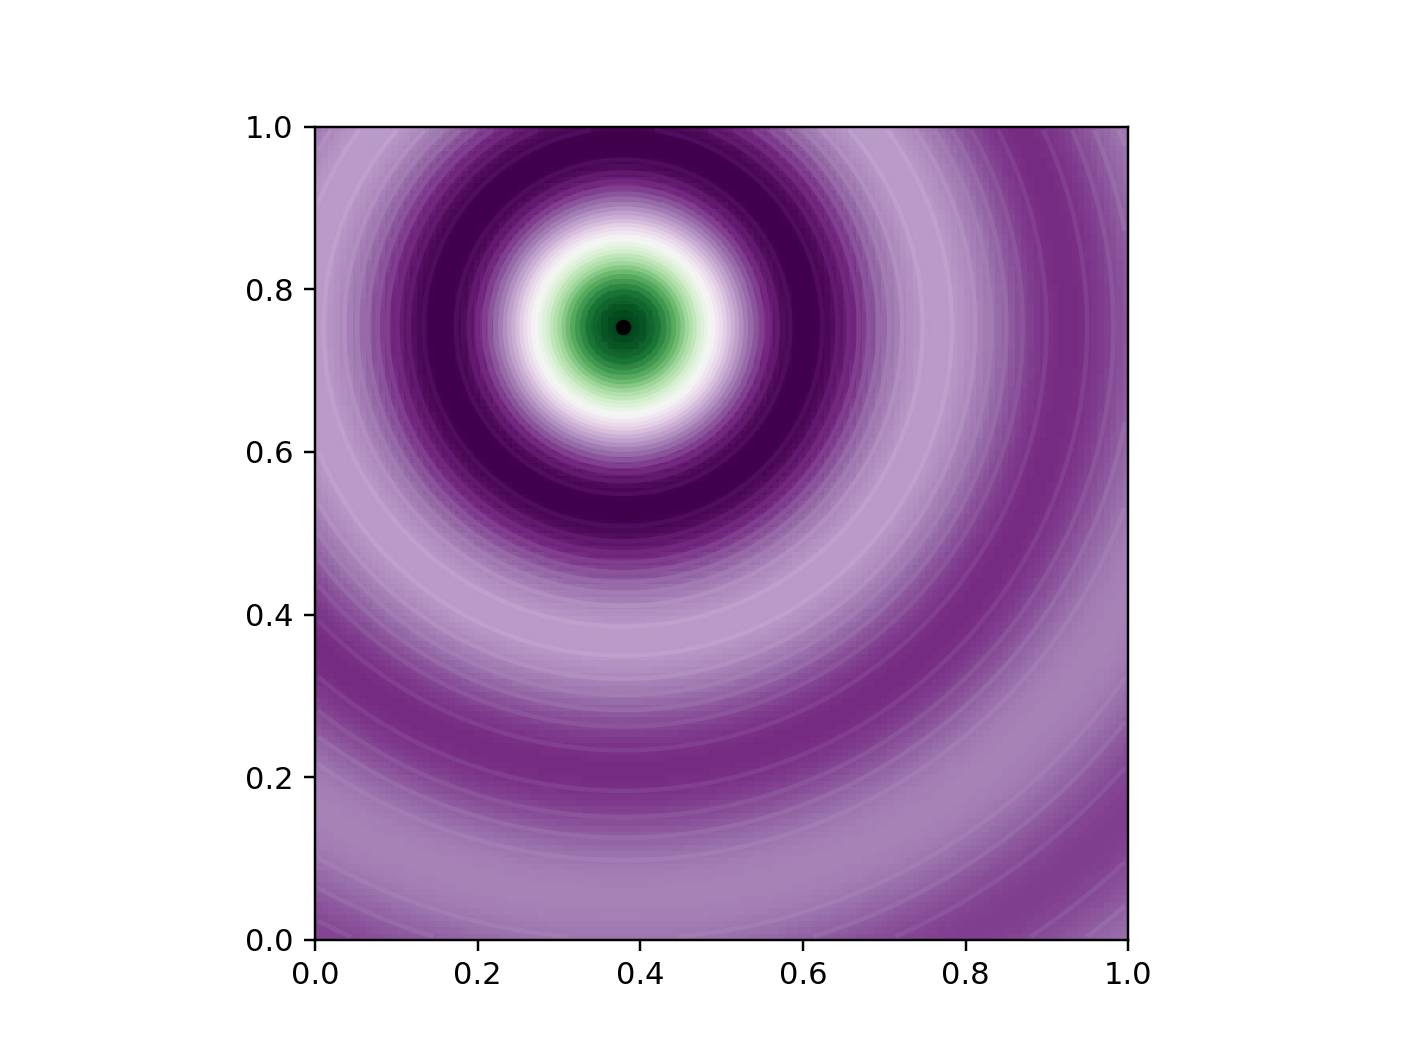

In [28]:
%matplotlib notebook
figure(1)
clf()

u = reshape(q,(N,N))

xe = linspace(a,b,N+1)
h = (b-a)/N;
xc = xe[:-1] + h/2;

imshow(u.T,extent=[a,b,a,b],origin='lower',cmap='PRGn');
contour(xc,xc,u.T,30,cmap='PRGn')

plot(xshift+h/2,yshift+h/2,'k.',ms=8);  # Image is shifted 

gca().set_aspect('equal')